## A)

### Statement

> Consider the following stochastic field: $E(x)=10(1+f(x))$
where $f(x)$ is a zero-mean stationary Gaussian field with unit variance and $x \in [0,5] (m)$.
The autocorrelation function for $f$ is $R_f (\tau) = \exp⁡(-|\tau|/2)$.
> 1. Use the Karhunen-Loeve series expansion method to generate $N = 5000$ realizations of the field $E(x)$.
> 2. Justify the number of terms you retained in the KL-expansion.
> 3. Calculate the ensemble average and the ensemble variance from these realizations. To which values would they converge as we increase the number $N$ of realizations?

### Answer

Throughout this document we will refer to *Stochastic Finite Element Methods by Vissarion Papadopoulos & Dimitris G. Giovanis* as ***the book***.

We focus on the Gaussian field $f(x)$. To perform analysis with it, we center its domain in $[-2.5, 2.5]$ and we have $a = 2.5$.

Our covariance function is of the form defined in (2.22) of the book. Solving for its eigenvalues $\lambda_n$ and eigenfunctions $\varphi_n$ we get (book 2.24 - 2.28) 

* For n = odd,
    $$
    \lambda_{n}=\frac{2 b}{1+\omega_{n}^{2} b^{2}}, \quad \varphi_{n}(x)=c_{n} \cos \left(\omega_{n} x\right)
    $$
    where $c_n$ is given by 
    $$
    c_{n}=\frac{1}{\sqrt{a+\frac{\sin \left(2 \omega_{n} a\right)}{2 \omega_{n}}}}
    $$
    and $\omega_{n}$ is obtained from the solution of
    $$
    \frac{1}{b}-\omega_{n} \tan \left(\omega_{n} a\right)=0 \quad \text { in the range }\left[(n-1) \frac{\pi}{a},\left(n-\frac{1}{2}\right) \frac{\pi}{a},\right]
    $$

*  For $n \geq 2$ and $n=$ even,
    $$
    \lambda_{n}=\frac{2 b}{1+\omega_{n}^{2} b^{2}}, \quad \varphi_{n}(x)=l_{n} \sin \left(\omega_{n} x\right)
    $$
    with
    $$
    l_{n}=\frac{1}{\sqrt{a-\frac{\sin \left(2 \omega_{n} a\right)}{2 \omega_{n}}}}
    $$
    and $\omega_{n}$ being the solution of
    $$
    \frac{1}{b} \tan \left(\omega_{n} a\right)+\omega_{n}=0 \quad \text { in the range }\left[\left(n-\frac{1}{2}\right) \frac{\pi}{a}, n \frac{\pi}{a},\right]
    $$

These equations will be solved numerically.

---

The truncated Karhunen-Loeve expansion of $M$ principal components is
$$\hat{f}_M(x) = \sum_{n=1}^{M} \sqrt{\lambda_n} \varphi_n(x - a) \xi_n$$
where $\xi_n$ are independent standard normal variables since the process is Gaussian (book page 31).

Since $\xi_n$ are uncorrelated (independent actually) and with variance 1 we have that (book 2.21)

$$\textrm{Var}\left[\hat{f}_M(x)\right] = \sum_{n=1}^{M} \lambda_n \varphi_n^2(x - a)$$

Integrating over all $x$, since we have that $\varphi_n$ are orthonormal, we get the *total explained variance* $\sum_{n=1}^{M} \lambda_n$

Since the variance of $f(x)$ is always 1, integrating it over the domain gives us *total variance* 5.

Therefore the *total explained variance ratio* is given by $\frac{1}{5} \sum_{n=1}^{M} \lambda_n$ and a reasonable value for it is 0.99. This is how we will choose our $M$.

---

We calculate the expected ensemble mean and variance. We use the again the fact that $\xi_n$ are uncorrelated with mean 0 and variance 1. We also use the fact that the eigenvalues are all non negative since the covariance function is positive semidefinite (Mercer's theorem).

We have that $\forall x \in [0, 5]$

$$
\begin{align*}
\textrm{E}\left[\hat{f}_M(x)\right] &= \sum_{n=1}^{M} \sqrt{\lambda_n} \varphi_n(x - a) \textrm{E}\left[ \xi_n \right] = 0\\
\textrm{Var}\left[\hat{f}_M(x)\right] &= \sum_{n=1}^{M} \lambda_n \varphi_n^2(x - a) \leq \sum_{n=1}^{\infty} \lambda_n \varphi_n^2(x - a) = \textrm{Var}[f(x)] = 1
\end{align*}
$$


Thus, $\forall x \in [0, 5]$

$$
\begin{align*}
\textrm{E}\left[ \hat{E}_M(x) \right] &= \textrm{E}\left[ 10(1 + \hat{f}_M(x)) \right] = 10  (1 + \textrm{E}\left[ \hat{f}_M(x) \right] ) = 10\\
\textrm{Var}\left[ \hat{E}_M(x) \right] &= 100 \; \textrm{Var}\left[ \hat{f}_M(x) \right] \leq 100
\end{align*}
$$

with the upper bound on the variance being tighter as $M$ increases (equality when $M \to \infty$)

---


In the following, we calculate the first $M$ eigenvalues needed to achieve $>99\%$ explained variance.

Explained  99.02% of the variance with 52 components


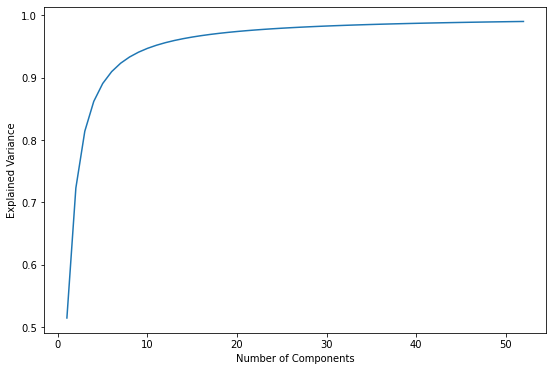

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt


RANDOM_STATE = 21


a = 2.5
b = 2


def eq_odd(omega):
    return 1/b - omega * np.tan(omega * a)

def eq_even(omega):
    return 1/b * np.tan(omega * a) + omega

def get_lam(omega):
    return 2*b / (1 + (omega * b)**2)


ratio_thresh = 0.99
total_variance = 2 * a


lams, omegas = [], []
explained_variance = 0
k = 1

while explained_variance / total_variance < ratio_thresh:
    # Intervals shown in the book seem to be incorrect.
    # The intervals used here are corrections by Spyros Rigas.
    omega1 = fsolve(eq_odd, (k - 1) * np.pi/a + 1e-4).item()
    lam1 = get_lam(omega1)
    
    omega2 = fsolve(eq_even, (k - 0.5) * np.pi/a + 1e-4).item()
    lam2 = get_lam(omega2)
    
    lams.extend((lam1, lam2))
    omegas.extend((omega1, omega2))
    
    explained_variance += lam1 + lam2
    k += 1

lams = np.array(lams)
omegas = np.array(omegas)


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.arange(1, 1 + len(lams)), np.cumsum(lams/5))
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')

print(f'Explained {explained_variance / total_variance: .2%} of the variance with {len(lams)} components')


With the values that we found, we simulate 5000 instances of the process.

In [2]:
resolution = 1_000
xs = np.linspace(-a, a, resolution)

cs = np.empty_like(omegas)
cs[::2] = 1 / np.sqrt(a + np.sin(2*omegas[::2]*a) / (2*omegas[::2]))
cs[1::2] = 1 / np.sqrt(a - np.sin(2*omegas[1::2]*a) / (2*omegas[1::2]))

phis = np.empty((len(omegas), len(xs)))
phis[::2] = cs[::2][..., np.newaxis] * np.cos(omegas[::2][..., np.newaxis] * xs)
phis[1::2] = cs[1::2][..., np.newaxis] * np.sin(omegas[1::2][..., np.newaxis] * xs)

N = 5_000
sims = []
rng = np.random.default_rng(RANDOM_STATE)
for i in range(N):
    xis = rng.normal(0, 1, len(phis))
    f = phis.T @ (np.sqrt(lams) * xis)
    E = 10 * (1 + f)
    sims.append(E)
sims = np.array(sims)

Finally we plot a few instances as well as the ensemble mean and ensemble variance.

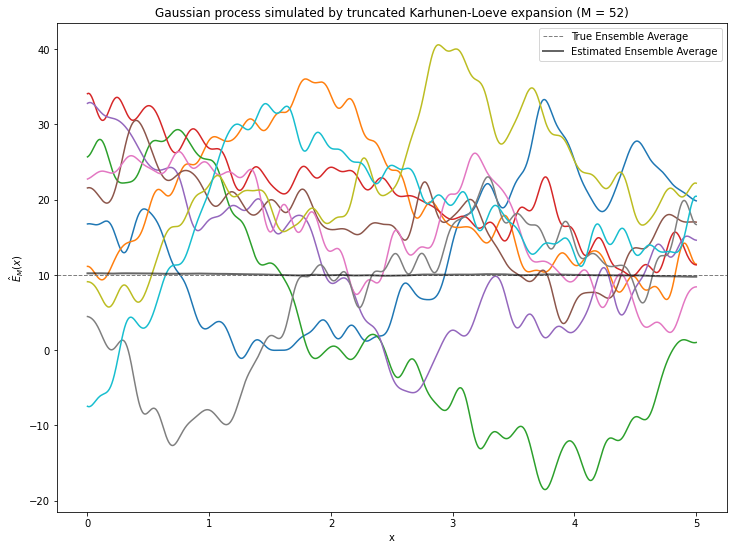

In [3]:
fig, ax = plt.subplots(figsize=(12, 9))
domain = np.linspace(0, 5, resolution)
for i in range(10):
    ax.plot(domain, sims[i])
ax.axhline(10, linestyle='--', linewidth=1, color='grey', label='True Ensemble Average')
ax.plot(domain, np.mean(sims, 0), linestyle='-', linewidth=2, color='black', alpha=0.6, label='Estimated Ensemble Average')
ax.set_title(f'Gaussian process simulated by truncated Karhunen-Loeve expansion (M = {len(lams)})')
ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{E}_{M}(x)$')
ax.legend()
plt.show()

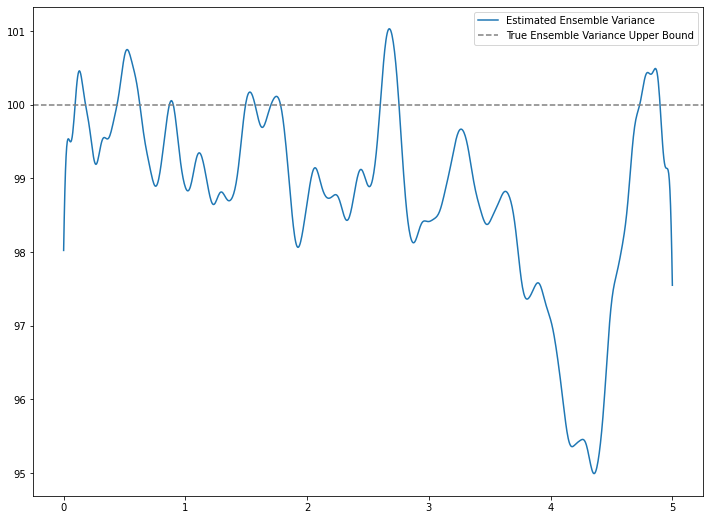

In [4]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(domain, np.var(sims, 0), label='Estimated Ensemble Variance')
ax.axhline(100, color='grey', linestyle='--', label='True Ensemble Variance Upper Bound')
ax.legend()
plt.show()

## B) 

### Statement

> Consider the zero-mean Gaussian process $X(t), \; t \in [0, 10] \; \textrm{(sec)}$,  which has the following one-sided power-spectrum
> $$
G(\omega) =
\begin{cases}
    \omega - 1, & 1 \leq \omega \leq 2 \\
    3 - \omega, & 2 < \omega \leq 3 \\
    0, & \textrm{otherwise}
\end{cases}$$ 
> 1. Use the Spectral Representation method to generate $N=5000$ time-histories (realizations) of the process $X(t)$.
> 2. Calculate the ensemble average and the ensemble variance from these time-histories. To which values would they converge as we increased the number $N$ of realizations.
> 3. 1Calculate the temporal average and temporal variance from a single realization. What do you observe?


### Answer

***TODO***: Move this down

We compute the autocorrelation fuction of the stationary Gaussian process by using the relation (book 1.37)
$$
R_X(\tau) = 2 \int_0^\infty G_x(\omega) \cos(\omega \tau) d\omega
$$

We have
$$
\begin{align*}
R_X(\tau) &= 2 \int_1^2 (\omega - 1) \cos(\omega \tau) d\omega + 2 \int_2^3 (3 - \omega) \cos(\omega \tau) d\omega \\
    &\stackrel{\textrm{Wolfram}}{=} \frac{8}{\tau^2} \sin^2 \left( \frac{\tau}{2} \right) \cos(2\tau)
\end{align*}
$$

The truncated Spectral Representation of the process $X$ at $M$ terms is (book 2.55)

$$
\hat{X} (t) = \sqrt2 \sum_{n=0}^{M-1} A_n \cos(\omega_n t + \Phi_n)
$$


$$
\begin{align*}
A_n &= \sqrt{2 G_X(\omega_n) \Delta\omega}, \quad \textrm{for} \  n = 0, 1, \dots, M-1\\
\Delta\omega &= \frac{\omega_{\textrm{upper}} - \omega_{\textrm{lower}} }{M - 1} = \frac{2}{M - 1}\\
\omega_0 &= \omega_{\textrm{lower}} = 1\\
\omega_n &= \omega_0 + n \Delta\omega = 1 + \frac{2n}{M-1}\\
\Phi_n &\sim \mathcal{U}(0, 2\pi)\\
\end{align*}
$$

where


In [5]:
N = 5_000
M = 80
resolution = 1_000
rng = np.random.default_rng(RANDOM_STATE)

ts = np.linspace(0, 10, resolution)
omegas = np.linspace(1, 3, M)
delta = omegas[1] - omegas[0]
Gs = np.where(omegas <= 2, omegas - 1, 3 - omegas)
As = np.sqrt(2 * delta * Gs)
omega_t = np.outer(ts, omegas)

sims = []
for _ in range(N):
    Phis = rng.uniform(0, 2*np.pi, (resolution, M))
    cosines = np.cos(omega_t + Phis)
    Xs = 2**0.5 * (cosines @ As)
    sims.append(Xs)    
sims = np.array(sims)


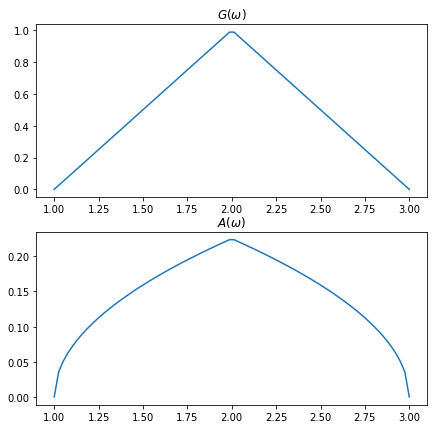

In [6]:
fig, axs = plt.subplots(2, figsize=(7, 7))
axs[0].plot(omegas, Gs)
axs[0].set_title(r'$G(\omega)$')
axs[1].plot(omegas, As)
axs[1].set_title(r'$A(\omega)$')
plt.show()

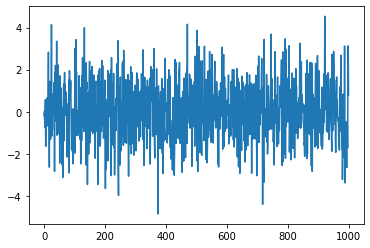

In [7]:
plt.plot(sims[0])  # TODO: This has to be wrong